<a href="https://colab.research.google.com/github/EkaSulistyawan/basic-mnist-experiment/blob/main/assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1
- I Gede Eka Sulistyawan
- C1WM9001

In [ ]:
#####################################################
### --- We modify the dataloader in this block ---###
#####################################################

from __future__ import print_function
import torchvision.datasets.vision as vision
import warnings
from PIL import Image
import os
import os.path
import random
import numpy as np
import torch
import codecs
# from torchvision.datasets.utils import download_url, download_and_extract_archive,   extract_archive, \
#    makedir_exist_ok, verify_str_arg
from torchvision.datasets.utils import download_url, download_and_extract_archive, extract_archive, \
    verify_str_arg

# This class is copied from torchvision.datasets.MNIST
class MyMNIST(vision.VisionDataset):

    def __init__(self, root, train=True, transform=None, target_transform=None,
                 download=False, limit_data=None):
        super(MyMNIST, self).__init__(root, transform=transform,
                                    target_transform=target_transform)
        self.train = train  # training set or test set

        # ------- We can ingore this block -------
        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')
        if self.train:
            data_file = self.training_file
        else:
            data_file = self.test_file
        # -----------------------------------------------

        # We change the lines below; these specify how the data are loaded.
        # self.data contain images (type 'torch.Tensor' of [num_images, H, W])
        # self.targets contain labels (class ids) (type 'torch.Tensor' of [num_images])
        # images and labels are stored in the same
        self.data, self.targets = torch.load(os.path.join(self.processed_folder, data_file))

        # We use only the images and lables whose indeces are in the range of 0..limit_data-1.
        if not limit_data is None:
          self.data    = self.data[   :limit_data, :,:]
          self.targets = self.targets[:limit_data]
          if self.train:
            print("[WRN]: Training Data is limited, only the first "+str(self.data.size(0))+" samples will be used.")
          else:
            print("[WRN]: Test Data is limited, only the first "   +str(self.data.size(0))+" samples will be used.")


    def __getitem__(self, index):
        # We extract the image and label of the specified 'index'.
        img, target = self.data[index], int(self.targets[index])

        # Prepare for self.transform below.
        img = Image.fromarray(img.numpy(), mode='L')

        # Transform img.
        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.data)


# ---------------------- We just leave the code from here as original -----------------
    """`MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.

    Args:
        root (string): Root directory of dataset where ``MNIST/processed/training.pt``
            and  ``MNIST/processed/test.pt`` exist.
        train (bool, optional): If True, creates dataset from ``training.pt``,
            otherwise from ``test.pt``.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """

    urls = [
        'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz',
    ]
    training_file = 'training.pt'
    test_file = 'test.pt'
    classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four',
               '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

    @property
    def train_labels(self):
        warnings.warn("train_labels has been renamed targets")
        return self.targets

    @property
    def test_labels(self):
        warnings.warn("test_labels has been renamed targets")
        return self.targets

    @property
    def train_data(self):
        warnings.warn("train_data has been renamed data")
        return self.data

    @property
    def test_data(self):
        warnings.warn("test_data has been renamed data")
        return self.data

    @property
    def raw_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'raw')

    @property
    def processed_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'processed')

    @property
    def class_to_idx(self):
        return {_class: i for i, _class in enumerate(self.classes)}

    def _check_exists(self):
        return (os.path.exists(os.path.join(self.processed_folder,
                                            self.training_file)) and
                os.path.exists(os.path.join(self.processed_folder,
                                            self.test_file)))

    def download(self):
        """Download the MNIST data if it doesn't exist in processed_folder already."""

        if self._check_exists():
            return

        # makedir_exist_ok(self.raw_folder)
        # makedir_exist_ok(self.processed_folder)
        os.makedirs(self.raw_folder, exist_ok=True)
        os.makedirs(self.processed_folder, exist_ok=True)

        # download files
        for url in self.urls:
            filename = url.rpartition('/')[2]
            download_and_extract_archive(url, download_root=self.raw_folder, filename=filename)

        # process and save as torch files
        print('Processing...')

        training_set = (
            read_image_file(os.path.join(self.raw_folder, 'train-images-idx3-ubyte')),
            read_label_file(os.path.join(self.raw_folder, 'train-labels-idx1-ubyte'))
        )
        test_set = (
            read_image_file(os.path.join(self.raw_folder, 't10k-images-idx3-ubyte')),
            read_label_file(os.path.join(self.raw_folder, 't10k-labels-idx1-ubyte'))
        )
        with open(os.path.join(self.processed_folder, self.training_file), 'wb') as f:
            torch.save(training_set, f)
        with open(os.path.join(self.processed_folder, self.test_file), 'wb') as f:
            torch.save(test_set, f)

        print('Done!')

    def extra_repr(self):
        return "Split: {}".format("Train" if self.train is True else "Test")

def read_label_file(path):
    with open(path, 'rb') as f:
        x = read_sn3_pascalvincent_tensor(f, strict=False)
    assert(x.dtype == torch.uint8)
    assert(x.ndimension() == 1)
    return x.long()


def read_image_file(path):
    with open(path, 'rb') as f:
        x = read_sn3_pascalvincent_tensor(f, strict=False)
    assert(x.dtype == torch.uint8)
    assert(x.ndimension() == 3)
    return x

def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)


def open_maybe_compressed_file(path):
    """Return a file object that possibly decompresses 'path' on the fly.
       Decompression occurs when argument `path` is a string and ends with '.gz' or '.xz'.
    """
    if not isinstance(path, torch._six.string_classes):
        return path
    if path.endswith('.gz'):
        import gzip
        return gzip.open(path, 'rb')
    if path.endswith('.xz'):
        import lzma
        return lzma.open(path, 'rb')
    return open(path, 'rb')


def read_sn3_pascalvincent_tensor(path, strict=True):
    """Read a SN3 file in "Pascal Vincent" format (Lush file 'libidx/idx-io.lsh').
       Argument may be a filename, compressed filename, or file object.
    """
    # typemap
    if not hasattr(read_sn3_pascalvincent_tensor, 'typemap'):
        read_sn3_pascalvincent_tensor.typemap = {
            8: (torch.uint8, np.uint8, np.uint8),
            9: (torch.int8, np.int8, np.int8),
            11: (torch.int16, np.dtype('>i2'), 'i2'),
            12: (torch.int32, np.dtype('>i4'), 'i4'),
            13: (torch.float32, np.dtype('>f4'), 'f4'),
            14: (torch.float64, np.dtype('>f8'), 'f8')}
    # read
    with open_maybe_compressed_file(path) as f:
        data = f.read()
    # parse
    magic = get_int(data[0:4])
    nd = magic % 256
    ty = magic // 256
    assert nd >= 1 and nd <= 3
    assert ty >= 8 and ty <= 14
    m = read_sn3_pascalvincent_tensor.typemap[ty]
    s = [get_int(data[4 * (i + 1): 4 * (i + 2)]) for i in range(nd)]
    parsed = np.frombuffer(data, dtype=m[1], offset=(4 * (nd + 1)))
    assert parsed.shape[0] == np.prod(s) or not strict
    return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Train Validation Test Split

In [ ]:
from   torchvision import datasets as datasets
import torchvision.transforms as transforms
import torch.utils as utils
import matplotlib.pyplot as plt
import torch
import torchvision

In [ ]:
# https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb#file-data_loader-py
# This is an example for the MNIST dataset (formerly CIFAR-10).
# There's a function for creating a train and validation iterator.
# There's also a function for creating a test iterator.
# Inspired by https://discuss.pytorch.org/t/feedback-on-pytorch-for-kaggle-competitions/2252/4

# Adapted for MNIST by github.com/MatthewKleinsmith

import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

def get_train_valid_loader(data_dir,
                           batch_size,
                           random_seed,
                           transform,
                           valid_size=0.2,
                           shuffle=True,
                           num_workers=1,
                           pin_memory=True,
                           limit_=60000
                           ):


    #normalize = transforms.Normalize((0.1307,), (0.3081,))  # MNIST

    # define transforms
    #valid_transform = transforms.Compose([
    #        transforms.ToTensor(),
    #        normalize
    #    ])
    #
    #train_transform = transforms.Compose([
    #    transforms.ToTensor(),
    #    normalize
    #])

    valid_transform = transform
    train_transform = transform

    # load the dataset FULL
    #train_dataset = datasets.MNIST(root=data_dir, train=True,
    #            download=True, transform=train_transform)

    #valid_dataset = datasets.MNIST(root=data_dir, train=True,
    #            download=True, transform=valid_transform)

    # subset
    train_dataset = MyMNIST(root=data_dir, train=True,
                download=True, transform=train_transform,limit_data=limit_)

    valid_dataset = MyMNIST(root=data_dir, train=True,
                download=True, transform=valid_transform,limit_data=limit_)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset,
                    batch_size=batch_size, sampler=train_sampler,
                    num_workers=num_workers, pin_memory=pin_memory)

    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                    batch_size=batch_size, sampler=valid_sampler,
                    num_workers=num_workers, pin_memory=pin_memory)


    return (train_loader, valid_loader)

def get_test_loader(data_dir,
                    batch_size,
                    transform,
                    shuffle=True,
                    num_workers=1,
                    pin_memory=True
                    ):

    # normalize = transforms.Normalize((0.1307,), (0.3081,))  # MNIST

    # define transform
    #transform = transforms.Compose([
    #    transforms.ToTensor(),
    #    normalize
    #])

    dataset = datasets.MNIST(root=data_dir,
                               train=False,
                               download=True,
                               transform=transform)

    data_loader = torch.utils.data.DataLoader(dataset,
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              pin_memory=pin_memory)

    return data_loader

# Load the data

In [ ]:
# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

# ----------------- define the training set - Version 1 -----------------
#MNISTtrain = datasets.MNIST(root='./data', train=True, download=True, transform=normFunc)
#trainLoad = torch.utils.data.DataLoader(MNISTtrain,
#                                          batch_size=50,
#                                          shuffle=True,
#                                          num_workers=2)

# ----------------- define the test set - Version 1 -----------------
#MNISTtest = datasets.MNIST(root='./data', train=False, download=True, transform=normFunc)
#testLoad = torch.utils.data.DataLoader(MNISTtest,
#                                          batch_size=100,
#                                          shuffle=False,
#                                          num_workers=2)

# ----------------- define the training/validation set - Version 2 -----------------
def load_data(tfunc):

  #normFunc = torchvision.transforms.Compose([
  #                              torchvision.transforms.ToTensor(),
  #                              torchvision.transforms.Normalize(
  #                                (0.1307,), (0.3081,))
  #                            ])
  trainLoad,valLoad = get_train_valid_loader(data_dir='./data',valid_size=0.0,batch_size=50,random_seed = 42,limit_=1000,transform=tfunc)
  testLoad = get_test_loader(data_dir='./data',batch_size=100,shuffle=False,transform=tfunc)
  return trainLoad,testLoad

cpu


# Create Models

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Model Description
1. Full LeNet
2. LeNet final layer dropped (only 2 Conv layer), FC retained
3. LeNet only first convolutional layer, FC retained
4. LeNet, 1 FC layer only

In [ ]:
class Model1(nn.Module):
  def __init__(self,input_dim=1,num_class=10):
    super(Model1,self).__init__()

    # Based on

    self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1,padding=2),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
        nn.ReLU()
    )


    self.fc_layer = nn.Sequential(
        nn.Linear(in_features=120,out_features=84),
        nn.ReLU(),
        nn.Linear(in_features=84,out_features=10),
    )

  def forward(self,x):
    x = self.conv_layer(x)
    x = torch.flatten(x,1)
    x = self.fc_layer(x)

    return x

In [ ]:
print(Model1())

Model1(
  (conv_layer): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [ ]:
class Model2(nn.Module):
  def __init__(self,input_dim=1,num_class=10):
    super(Model2,self).__init__()

    # Based on

    self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1,padding=2),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
        nn.ReLU()
    )


    self.fc_layer = nn.Sequential(
        nn.Linear(in_features=1600,out_features=160),
        nn.ReLU(),
        nn.Linear(in_features=160,out_features=10),
    )

  def forward(self,x):
    x = self.conv_layer(x)
    x = torch.flatten(x,1)
    x = self.fc_layer(x)

    return x

In [ ]:
print(Model2())

Model2(
  (conv_layer): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=1600, out_features=160, bias=True)
    (1): ReLU()
    (2): Linear(in_features=160, out_features=10, bias=True)
  )
)


In [ ]:
class Model3(nn.Module):
  def __init__(self,input_dim=1,num_class=10):
    super(Model3,self).__init__()

    # Based on

    self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1,padding=2),
        nn.ReLU(),
    )


    self.fc_layer = nn.Sequential(
        nn.Linear(in_features=4704,out_features=160),
        nn.ReLU(),
        nn.Linear(in_features=160,out_features=10),
    )

  def forward(self,x):
    x = self.conv_layer(x)
    x = torch.flatten(x,1)
    x = self.fc_layer(x)

    return x

In [ ]:
print(Model3())

Model3(
  (conv_layer): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=4704, out_features=160, bias=True)
    (1): ReLU()
    (2): Linear(in_features=160, out_features=10, bias=True)
  )
)


In [ ]:
class Model4(nn.Module):
  def __init__(self,input_dim=1,num_class=10):
    super(Model4,self).__init__()

    # Based on

    self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1,padding=2),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
        nn.ReLU()
    )


    self.fc_layer = nn.Sequential(
        nn.Linear(in_features=120,out_features=10),
    )

  def forward(self,x):
    x = self.conv_layer(x)
    x = torch.flatten(x,1)
    x = self.fc_layer(x)

    return x

In [ ]:
print(Model4())

Model4(
  (conv_layer): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=120, out_features=10, bias=True)
  )
)


In [ ]:
class Model5(nn.Module):
  def __init__(self,input_dim=1,num_class=10):
    super(Model5,self).__init__()

    # Based on

    self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1,padding=2),
        nn.ReLU(),
    )


    self.fc_layer = nn.Sequential(
        nn.Linear(in_features=4704,out_features=2352),
        nn.ReLU(),
        nn.Linear(in_features=2352,out_features=1676),
        nn.ReLU(),
        nn.Linear(in_features=1676,out_features=838),
        nn.ReLU(),
        nn.Linear(in_features=838,out_features=419),
        nn.ReLU(),
        nn.Linear(in_features=419,out_features=210),
        nn.ReLU(),
        nn.Linear(in_features=210,out_features=10),
    )

  def forward(self,x):
    x = self.conv_layer(x)
    x = torch.flatten(x,1)
    x = self.fc_layer(x)

    return x

In [ ]:
print(Model5())

Model5(
  (conv_layer): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=4704, out_features=2352, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2352, out_features=1676, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1676, out_features=838, bias=True)
    (5): ReLU()
    (6): Linear(in_features=838, out_features=419, bias=True)
    (7): ReLU()
    (8): Linear(in_features=419, out_features=210, bias=True)
    (9): ReLU()
    (10): Linear(in_features=210, out_features=10, bias=True)
  )
)


In [ ]:
#net = Model1().to(DEVICE)
#print(net)
#nets = [
#   Model1(),
#   Model2(),
#   Model3(),
#   Model4(),
#   Model5()
#]

nets = [
        Model1()
]

## Test 1 Transformations

In [ ]:
# transformation
t0 = torchvision.transforms.Compose([
                                     torchvision.transforms.ToTensor(),
                                     torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                     ])

t1 = torchvision.transforms.Compose([
                                     torchvision.transforms.RandomSolarize(0.5),
                                     torchvision.transforms.ToTensor(),
                                     torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                     ])

t2 = torchvision.transforms.Compose([
                                     torchvision.transforms.RandomAffine(degrees=(0,90),scale=(0.5,1),translate=(0,0.2)),
                                     torchvision.transforms.ToTensor(),
                                     torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                     ])

t3 = torchvision.transforms.Compose([
                                     torchvision.transforms.RandomPosterize(bits=1),
                                     torchvision.transforms.ToTensor(),
                                     torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                     ])

t4 = torchvision.transforms.Compose([
                                     torchvision.transforms.RandomInvert(),
                                     torchvision.transforms.ToTensor(),
                                     torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                     ])

t5 = torchvision.transforms.Compose([
                                     torchvision.transforms.GaussianBlur(kernel_size=3),
                                     torchvision.transforms.ToTensor(),
                                     torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                     ])

tss = [
       t0,
       t5,
       t2,
       t3,
       t4,
       t1
       ]

In [ ]:
# validate is portion of training, not used
def validate_model():
  print("Testing the network...")
  net.eval()
  total_num   = 0
  correct_num = 0
  for test_iter, test_data in enumerate(valLoad):
    # Get one batch of test samples
    inputs, labels = test_data
    bch = inputs.size(0)
    #inputs = inputs.view(bch, -1) <-- We don't need to reshape inputs here (we are using CNNs).

    # Move inputs and labels into GPU
    inputs = inputs.cuda()
    labels = torch.LongTensor(list(labels)).cuda()

    # Forward
    outputs = net(inputs)

    # Get predicted classes
    _, pred_cls = torch.max(outputs, 1)
#     if total_num == 0:
#        print("True label:\n", labels)
#        print("Prediction:\n", pred_cls)
    # Record test result
    correct_num+= (pred_cls == labels).float().sum().item()
    total_num+= bch
  net.train()
  print(total_num)
  print("Accuracy: "+"%.3f"%(correct_num/float(total_num)))
  return correct_num/float(total_num)

In [ ]:
import torch.optim as optim
import time

In [ ]:
def test_model():
  #print("Testing the network...")
  net.eval()
  total_num   = 0
  correct_num = 0

  for test_iter, test_data in enumerate(testLoad):
    # Get one batch of test samples
    inputs, labels = test_data
    bch = inputs.size(0)
    #inputs = inputs.view(bch, -1) <-- We don't need to reshape inputs here (we are using CNNs).

    # Move inputs and labels into GPU
    inputs = inputs.to(DEVICE)
    labels = torch.LongTensor(list(labels)).to(DEVICE)

    # Forward
    outputs = net(inputs)

    # Get predicted classes
    _, pred_cls = torch.max(outputs, 1)
#     if total_num == 0:
#        print("True label:\n", labels)
#        print("Prediction:\n", pred_cls)
    # Record test result
    correct_num+= (pred_cls == labels).float().sum().item()
    total_num+= bch
  net.train()
  #print(total_num)
  #print("Accuracy: "+"%.3f"%(correct_num/float(total_num)))
  return correct_num/float(total_num)

In [ ]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [ ]:
all_train = {}
all_test = {}
all_time = {}

set_epochs = 51


for inett,ts in enumerate(tss):
  nett = nets[0] # only one model
  nett.apply(weight_reset)
  print(f"Working on model {inett}")
  # load data
  trainLoad, testLoad = load_data(tfunc=ts)
  net = nett.to(DEVICE)

  accs = []
  trains = []
  elapsed = []

  # Optimizer and loss-function
  loss_func = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
  epoch = 0

  for epochs in range(1,51):
    running_loss = 0.0
    ct_num = 0
    total_batch = 0
    correct_num = 0

    start = time.time()

    for iteration, data in enumerate(trainLoad):
      # Take the inputs and the labels for 1 batch.
      inputs, labels = data
      bch = inputs.size(0)

      # Move inputs and labels into GPU
      inputs = inputs.to(DEVICE)
      labels = labels.to(DEVICE)

      # Remove old gradients for the optimizer.
      optimizer.zero_grad()

      # Compute result (Forward)
      outputs = net(inputs)

      # Get train pred class to calculate acc
      _, pred_cls = torch.max(outputs, 1)
      correct_num += (pred_cls == labels).float().sum().item()
      total_batch += bch

      # Compute loss
      loss    = loss_func(outputs, labels)


      # Calculate gradients (Backward)
      loss.backward()

      # Update parameters
      optimizer.step()

      #with torch.no_grad():
      running_loss += loss.item()
      ct_num+= 1


      # training
      #if iteration%50 == 49: #48
        #print("Iteration: "+str(iteration+1)+", Loss: "+str(running_loss/ct_num)+'.')
        #print("[Epoch: "+str(epoch+1)+"]"" --- Iteration: "+str(iteration+1)+", Loss: "+str(running_loss/ct_num)+'.')


      # Test
      #if iteration%300 == 299: # 240
      #  acc = test_model()
      #  accs.append(acc)

    # time
    stop = time.time()
    elapsed.append(stop-start)

    # training accuracy
    trainacc = correct_num/float(total_batch)
    trains.append(trainacc)

    # test accuracy
    acc = test_model()
    accs.append(acc)
    print(epochs)


  # save all
  all_train[inett] = trains
  all_test[inett] = accs
  all_time[inett] = elapsed

Working on model 0
[WRN]: Training Data is limited, only the first 1000 samples will be used.
[WRN]: Training Data is limited, only the first 1000 samples will be used.
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
Working on model 1
[WRN]: Training Data is limited, only the first 1000 samples will be used.
[WRN]: Training Data is limited, only the first 1000 samples will be used.
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
Working on model 2
[WRN]: Training Data is limited, only the first 1000 samples will be used.
[WRN]: Training Data is limited, only the first 1000 samples will be used.
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
Working on model 3
[WRN]: Training Data is limited, only the first 100

In [ ]:
# plot the accuracy
import matplotlib.pyplot as plt
import seaborn as sns

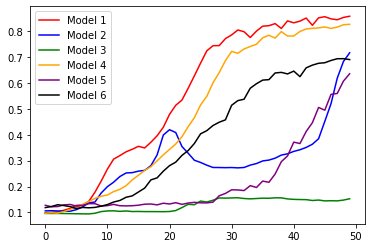

In [ ]:
plt.plot(all_test[0],c='red',label='Model 1') # Model 1
plt.plot(all_test[1],c='blue',label='Model 2') # Model 2
plt.plot(all_test[2],c='green',label='Model 3') # model 3
plt.plot(all_test[3],c='orange',label='Model 4') # model 4
plt.plot(all_test[4],c='purple',label='Model 5') # model 5
plt.plot(all_test[5],c='black',label='Model 6') # model 5

plt.legend()

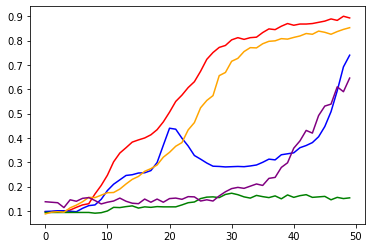

In [ ]:
plt.plot(all_train[0],c='red',label='Model 1')
plt.plot(all_train[1],c='blue',label='Model 2')
plt.plot(all_train[2],c='green',label='Model 3')
plt.plot(all_train[3],c='orange',label='Model 4')
plt.plot(all_train[4],c='purple',label='Model 5')

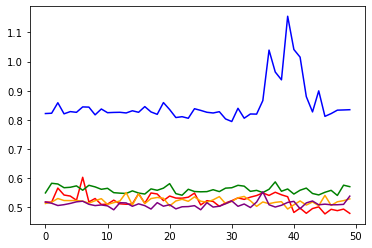

In [ ]:
plt.plot(all_time[0],c='red',label='Model 1')
plt.plot(all_time[1],c='blue',label='Model 2')
plt.plot(all_time[2],c='green',label='Model 3')
plt.plot(all_time[3],c='orange',label='Model 4')
plt.plot(all_time[4],c='purple',label='Model 5')

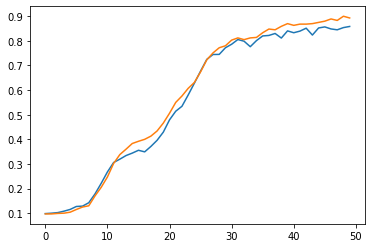

In [ ]:
plt.plot(all_test[0])
plt.plot(all_train[0])

In [ ]:
import pandas as pd

In [ ]:
pd.DataFrame(all_test).to_csv("save_accuracy_test.csv",index=False)
pd.DataFrame(all_train).to_csv("save_accuracy_train.csv",index=False)
pd.DataFrame(all_time).to_csv("save_time_train.csv",index=False)